## 1. Setup and Environment Preperation

In [67]:
import os
import torch
from transformers import RobertaTokenizer, AutoTokenizer, RobertaConfig, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import transformers
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import json
from datasets import Dataset, DatasetDict
import regex as re
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np
from datetime import datetime

In [4]:
root_folder = 'Crypto/'
os.chdir(root_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'Crypto/'

In [3]:
#!git clone https://github.com/artidoro/qlora.git

fatal: destination path 'qlora' already exists and is not an empty directory.


In [1]:
!pip install -r qlora/requirements.txt

  Using cached bitsandbytes-0.40.0-py3-none-any.whl.metadata (9.8 kB)
  Using cached transformers-4.31.0-py3-none-any.whl.metadata (116 kB)
  Using cached peft-0.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached accelerate-0.21.0-py3-none-any.whl.metadata (17 kB)
  Using cached einops-0.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached evaluate-0.4.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached sentencepiece-0.1.99-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached wandb-0.15.3-py3-none-any.whl.metadata (8.0 kB)
  Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached xxhash-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311

In [2]:
!pip install torch --upgrade
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git 
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install wandb --upgrade

  Using cached torch-2.3.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.wh

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity_info()

## 2. Data Loading and Preprocessing

In [11]:
train_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='train', verification_mode='no_checks', trust_remote_code=True)
test_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', verification_mode='no_checks', trust_remote_code=True)
val_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='validation', verification_mode='no_checks', trust_remote_code=True)

Approximation of runtime for full dataset
1057 rows = train_runtime': 7.2798s & 3 mins preprocessing = 3.12mins
79641 rows = train_runtime': 548s & 225 mins preprocessing = 234.13mins = 3.9h

In [288]:
FRACTION = 1

train_df = train_set.to_pandas().sample(frac=FRACTION, random_state=420)
test_df = test_set.to_pandas().sample(frac=FRACTION, random_state=420)
val_df = val_set.to_pandas().sample(frac=FRACTION, random_state=420)

In [289]:
train_df.head()

,address,source_code,bytecode,slither
44384,0xa49f8b3f4f8af2a68a15eec869f6cff06b217b86,/*\n Copyright 2021 Set Labs Inc.\n\n Li...,0x608060405234801561001057600080fd5b5060043610...,[4]
56556,0xc42a8afc770f1a3328a4dacd295905df7ac27cfe,/**\n *Submitted for verification at Etherscan...,0x608060405234801561001057600080fd5b5060043610...,[4]
9258,0x2587fa21554644f999f8f942d183cea9c0f45b82,/**\n *Submitted for verification at Etherscan...,0x60806040526004361061020f5760003560e01c806355...,"[5, 2]"
47332,0xaC21924eA1C0d5137797419b52f4dC2A04D04389,//SPDX-License-Identifier: Unlicense\npragma s...,0x608060405234801561001057600080fd5b5060043610...,[5]
6868,0x1bA1279715fd65f6098Ed79a577f30329751eb8a,/**\n *Submitted for verification at Etherscan...,0x60806040526004361061020f5760003560e01c80635c...,"[5, 2]"


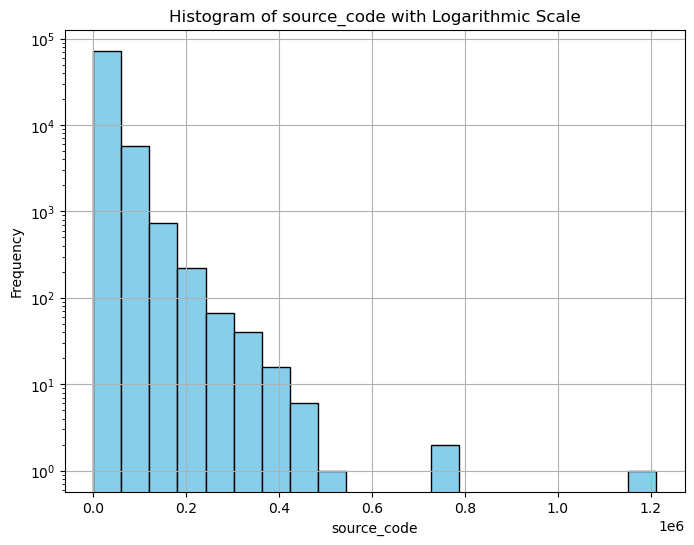

In [290]:
# Calculate string lengths
train_df['source_length'] = train_df['source_code'].apply(len)

# Plot histogram with logarithmic scale on y-axis
plt.figure(figsize=(8, 6))
plt.hist(train_df['source_length'], bins=20, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.xlabel('source_code')
plt.ylabel('Frequency')
plt.title('Histogram of source_code with Logarithmic Scale')
plt.grid(True)
plt.show()

In [298]:
test_df['source_length'] = test_df['source_code'].apply(len)
val_df['source_length'] = val_df['source_code'].apply(len)

train_df = train_df[train_df['source_length'] <= 4000]
test_df = test_df[test_df['source_length'] <= 4000]
val_df = val_df[val_df['source_length'] <= 4000]

/tmp/ipykernel_268/3142215593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['source_length'] = train_df['source_code'].apply(len)


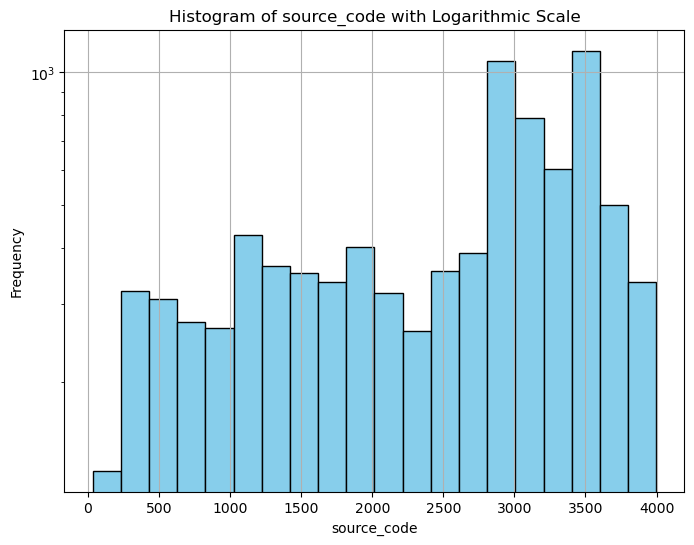

In [299]:
# Calculate string lengths
train_df['source_length'] = train_df['source_code'].apply(len)

# Plot histogram with logarithmic scale on y-axis
plt.figure(figsize=(8, 6))
plt.hist(train_df['source_length'], bins=20, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.xlabel('source_code')
plt.ylabel('Frequency')
plt.title('Histogram of source_code with Logarithmic Scale')
plt.grid(True)
plt.show()

In [300]:
train_df

,address,source_code,bytecode,slither,source_length
43559,0xa26ac15771d0cdb485d4e0489f7ad9c8f32ab4e1,pragma solidity ^0.4.18;\n\n/**\n * @title Saf...,0x6080604052600436106100ba576000357c0100000000...,"[3, 5]",2991
17360,0x4824b7595175417b81dfc9350941bf3a35afe8f6,pragma solidity ^0.4.20;\n\ncontract MyToken {...,0x60806040526004361061004c576000357c0100000000...,[4],903
5149,0x146b6c2b3248b800d91cc384821c426174042d58,/**\n *Submitted for verification at Etherscan...,0x6080604052600436106100d0576000357c0100000000...,[4],3622
5539,0x1622aafed9a6f0b59ef50a778bcb0cdbf990bf81,pragma solidity ^0.4.19;\n\ncontract Foo\n{\n ...,0x606060405260043610610041576000357c0100000000...,[4],147
66264,0xdda2360bf463ba8811fe7f760cd0864fe8a13dae,pragma solidity ^0.4.18;\n\n/**\n * @title Saf...,0x6080604052600436106100ba576000357c0100000000...,"[3, 5]",2991
...,...,...,...,...,...
60191,0xCD9dB6021749F25f13A6D4fF7D950d33bCb714e2,pragma solidity 0.5.17;\npragma experimental A...,0x608060405234801561001057600080fd5b5060043610...,[4],1434
43231,0xa1af9d98bf4b4e11e8a070423397c95eefe43f24,// SPDX-License-Identifier: MIT\npragma solidi...,0x608060405234801561001057600080fd5b5060043610...,[5],3225
38841,0x963c69cca9b9193581ea100bc2ca31322e30d463,pragma solidity ^0.4.11;\ncontract OHGLuangPra...,0x6060604052600436106100a4576000357c0100000000...,[4],1939
63547,0xd65f46aaf9ceb91c935f5dda0a32c4ce3e379c3d,pragma solidity ^0.4.18;\n\n/**\n * @title Saf...,0x6080604052600436106100ba576000357c0100000000...,"[3, 5]",2993


#### Filtering Source Code

In [301]:
def process_source_code(source_code):
    # Regex patterns
    security_kewords_regex = r"function[\s\S]*?\{.*?(transfer|call|send|require|assert)[\s\S]*?\}"
    events_regex = r"event[\s\S]*?;"
    variables_regex = r"(public|external|internal|private)[\s\S]*?;"
    details_regex = r"contract[\s\S]*?is[\s\S]*?\{"

    # Extract matches
    security_kewords = re.findall(security_kewords_regex, source_code)
    events = re.findall(events_regex, source_code)
    variables = re.findall(variables_regex, source_code)
    details = re.findall(details_regex, source_code)

    # Combine extracted code fragments
    extracted_fragments = security_kewords + events + variables + details

    # Function to clean up source code fragments
    def clean_code_fragments(fragments):
        cleaned_fragments = []
        for fragment in fragments:
            # Remove new lines and reduce multiple spaces to single space
            cleaned = re.sub(r'\s+', ' ', fragment).strip()
            # Append cleaned fragment to the list
            cleaned_fragments.append(cleaned)
        return cleaned_fragments

    # Clean the fragments
    cleaned_fragments = clean_code_fragments(extracted_fragments)

    # Function to organize and deduplicate code fragments
    def organize_fragments(fragments):
        contracts = {}
        for fragment in fragments:
            # Check if the fragment is a contract definition
            contract_match = re.search(r'contract\s+(\w+)', fragment)
            if contract_match:
                contract_name = contract_match.group(1)
                if contract_name not in contracts:
                    contracts[contract_name] = set()
                contracts[contract_name].add(fragment)
            else:
                # If not part of a contract, categorize by type (events, functions, etc.)
                type_match = re.search(r'^(event|function)', fragment)
                if type_match:
                    event_or_function = type_match.group(1)
                    if event_or_function not in contracts:
                        contracts[event_or_function] = set()
                    contracts[event_or_function].add(fragment)

        return contracts

    # Organize and deduplicate
    organized_code = organize_fragments(cleaned_fragments)

    # Function to convert organized code dictionary into a string
    def convert_to_string(organized_code):
        # Start with an empty string
        code_string = ""
        # Iterate over each category and its list of items
        for category, items in organized_code.items():
            code_string += f"\n{category}:\n"  # Add the category name
            for item in items:
                code_string += f"  {item}\n"  # Add each item in the category
        return code_string.strip()  # Return the final string, stripped of any leading/trailing whitespace

    # Convert the organized code to a string
    code_string = convert_to_string(organized_code)

    # Function to abstract the source code
    def abstract_source_code(code):
        # Remove detailed comments and metadata
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # Remove block comments
        code = re.sub(r'//.*', '', code)  # Remove line comments
        code = re.sub(r'event\s+(\w+)\(.*?\);', r'event \1;', code)
        code = re.sub(r'function\s+(\w+)\(.*?\)\s*{.*?}', r'function \1(params);', code, flags=re.DOTALL)
        code = re.sub(r'library\s+(\w+)\s*{', r'library \1 {', code)
        code = re.sub(r'\n\s*\n', '\n', code)  # Reduce multiple newlines to a single one
        return code

    # Apply the abstraction function
    abstracted_code = abstract_source_code(code_string)

    # Return the abstracted code
    return abstracted_code

# Process the source code
train_df['processed_source_code'] = train_df['source_code'].apply(process_source_code)
test_df['processed_source_code'] = test_df['source_code'].apply(process_source_code)
val_df['processed_source_code'] = val_df['source_code'].apply(process_source_code)

/tmp/ipykernel_268/2407292393.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['processed_source_code'] = train_df['source_code'].apply(process_source_code)


#### Chunking Source Code

In [303]:
def sliding_window_chunks(text, window_size, step_size):
    """
    Splits the text into overlapping chunks using a sliding window approach.
    """
    chunks = []
    text_length = len(text)
    for i in range(0, text_length, step_size):
        end = i + window_size
        if end >= text_length:
            end = text_length
        chunk = text[i:end]
        chunks.append(chunk)
        if end == text_length:
            break
    return chunks

def process_source_code_with_sliding_window(source_code, window_size=200, step_size=100):
    """
    Process the source code and split it into chunks using a sliding window approach.
    """
    # Split the source code into chunks using sliding window
    chunks = sliding_window_chunks(source_code, window_size, step_size)
    
    # Return the chunks
    return chunks

def apply_sliding_window(df, window_size=500, step_size=400):
    df_expanded = pd.DataFrame()
    for index, row in df.iterrows():
        source_code = row['source_code']
        chunks = process_source_code_with_sliding_window(source_code, window_size, step_size)
        for chunk in chunks:
            new_row = row.copy()
            new_row['processed_source_code'] = chunk
            df_expanded = df_expanded.append(new_row, ignore_index=True)
    return df_expanded

# Apply the function to train, test, and validation DataFrames
train_df_expanded = apply_sliding_window(train_df)
test_df_expanded = apply_sliding_window(test_df)
val_df_expanded = apply_sliding_window(val_df)

/tmp/ipykernel_268/3726766445.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)
/tmp/ipykernel_268/3726766445.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)
/tmp/ipykernel_268/3726766445.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)


#### Combined Approach of Sliding Window and Filtering

In [304]:
def process_source_code_simplified(source_code):
    # Regex patterns
    security_keywords_regex = r"function[\s\S]*?\{.*?(transfer|call|send|require|assert)[\s\S]*?\}"
    events_regex = r"event[\s\S]*?;"
    variables_regex = r"(public|external|internal|private)[\s\S]*?;"
    details_regex = r"contract[\s\S]*?is[\s\S]*?\{"

    # Extract matches
    security_keywords = re.findall(security_keywords_regex, source_code)
    events = re.findall(events_regex, source_code)
    variables = re.findall(variables_regex, source_code)
    details = re.findall(details_regex, source_code)

    # Combine extracted code fragments
    extracted_fragments = security_keywords + events + variables + details

    # Function to clean up source code fragments
    def clean_code_fragments(fragments):
        cleaned_fragments = []
        for fragment in fragments:
            # Remove new lines and reduce multiple spaces to single space
            cleaned = re.sub(r'\s+', ' ', fragment).strip()
            # Append cleaned fragment to the list
            cleaned_fragments.append(cleaned)
        return cleaned_fragments

    # Clean the fragments
    cleaned_fragments = clean_code_fragments(extracted_fragments)

    # Function to organize and deduplicate code fragments
    def organize_fragments(fragments):
        contracts = {}
        for fragment in fragments:
            # Check if the fragment is a contract definition
            contract_match = re.search(r'contract\s+(\w+)', fragment)
            if contract_match:
                contract_name = contract_match.group(1)
                if contract_name not in contracts:
                    contracts[contract_name] = set()
                contracts[contract_name].add(fragment)
            else:
                # If not part of a contract, categorize by type (events, functions, etc.)
                type_match = re.search(r'^(event|function)', fragment)
                if type_match:
                    event_or_function = type_match.group(1)
                    if event_or_function not in contracts:
                        contracts[event_or_function] = set()
                    contracts[event_or_function].add(fragment)
        return contracts

    # Organize and deduplicate
    organized_code = organize_fragments(cleaned_fragments)

    # Function to convert organized code dictionary into a string
    def convert_to_string(organized_code):
        # Start with an empty string
        code_string = ""
        # Iterate over each category and its list of items
        for category, items in organized_code.items():
            code_string += f"\n{category}:\n"  # Add the category name
            for item in items:
                code_string += f"  {item}\n"  # Add each item in the category
        return code_string.strip()  # Return the final string, stripped of any leading/trailing whitespace

    # Convert the organized code to a string
    code_string = convert_to_string(organized_code)

    # Function to abstract the source code
    def abstract_source_code(code):
        # Remove detailed comments and metadata
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # Remove block comments
        code = re.sub(r'//.*', '', code)  # Remove line comments
        # code = re.sub(r'event\s+(\w+)\(.*?\);', r'event \1;', code)
        # code = re.sub(r'function\s+(\w+)\(.*?\)\s*{.*?}', r'function \1(params);', code, flags=re.DOTALL)
        # code = re.sub(r'library\s+(\w+)\s*{', r'library \1 {', code)
        code = re.sub(r'\n\s*\n', '\n', code)  # Reduce multiple newlines to a single one
        return code

    # Apply the abstraction function
    abstracted_code = abstract_source_code(code_string)

    # Return the abstracted code
    return abstracted_code

def process_and_chunk_source_code(source_code, window_size=200, step_size=100):
    """
    Process the source code, then split it into chunks using a sliding window approach.
    """
    # Process the source code
    processed_code = process_source_code_simplified(source_code)
    
    # Split the processed code into chunks using sliding window
    chunks = sliding_window_chunks(processed_code, window_size, step_size)
    
    # Return the chunks
    return chunks

def apply_sliding_window(df, window_size=500, step_size=250):
    df_expanded = pd.DataFrame()
    for index, row in df.iterrows():
        source_code = row['source_code']
        chunks = process_and_chunk_source_code(source_code, window_size, step_size)
        for chunk in chunks:
            new_row = row.copy()
            new_row['processed_source_code'] = chunk
            df_expanded = df_expanded.append(new_row, ignore_index=True)
    return df_expanded

# Apply the function to train, test, and validation DataFrames
train_df_combined = apply_sliding_window(train_df)
test_df_combined = apply_sliding_window(test_df)
val_df_combined = apply_sliding_window(val_df)

/tmp/ipykernel_268/1871249461.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)
/tmp/ipykernel_268/1871249461.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)
/tmp/ipykernel_268/1871249461.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)


#### Tokenize Dataset

In [305]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def tokenize(source_code):
    return tokenizer.encode(source_code, 
                            padding="max_length", 
                            truncation=True, 
                            max_length=tokenizer.model_max_length)

loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-ba

In [306]:
train_df['tokenized'] = train_df['processed_source_code'].apply(tokenize)
train_df['token_count'] = train_df['processed_source_code'].apply(len)

test_df['tokenized'] = test_df['processed_source_code'].apply(tokenize)
test_df['token_count'] = test_df['processed_source_code'].apply(len)

val_df['tokenized'] = val_df['processed_source_code'].apply(tokenize)
val_df['token_count'] = val_df['processed_source_code'].apply(len)

/tmp/ipykernel_268/3873340288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokenized'] = train_df['processed_source_code'].apply(tokenize)
/tmp/ipykernel_268/3873340288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['token_count'] = train_df['processed_source_code'].apply(len)


In [307]:
train_df_expanded['tokenized'] = train_df_expanded['processed_source_code'].apply(tokenize)
train_df_expanded['token_count'] = train_df_expanded['processed_source_code'].apply(len)

test_df_expanded['tokenized'] = test_df_expanded['processed_source_code'].apply(tokenize)
test_df_expanded['token_count'] = test_df_expanded['processed_source_code'].apply(len)

val_df_expanded['tokenized'] = val_df_expanded['processed_source_code'].apply(tokenize)
val_df_expanded['token_count'] = val_df_expanded['processed_source_code'].apply(len)

In [308]:
train_df_combined['tokenized'] = train_df_combined['processed_source_code'].apply(tokenize)
train_df_combined['token_count'] = train_df_combined['processed_source_code'].apply(len)

test_df_combined['tokenized'] = test_df_combined['processed_source_code'].apply(tokenize)
test_df_combined['token_count'] = test_df_combined['processed_source_code'].apply(len)

val_df_combined['tokenized'] = val_df_combined['processed_source_code'].apply(tokenize)
val_df_combined['token_count'] = val_df_combined['processed_source_code'].apply(len)

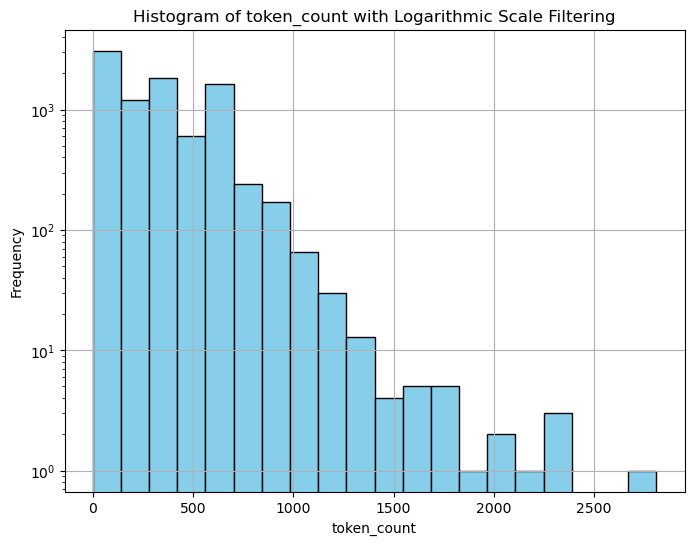

In [309]:
# Plot histogram with logarithmic scale on y-axis
plt.figure(figsize=(8, 6))
plt.hist(train_df['token_count'], bins=20, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.xlabel('token_count')
plt.ylabel('Frequency')
plt.title('Histogram of token_count with Logarithmic Scale Filtering')
plt.grid(True)
plt.show()

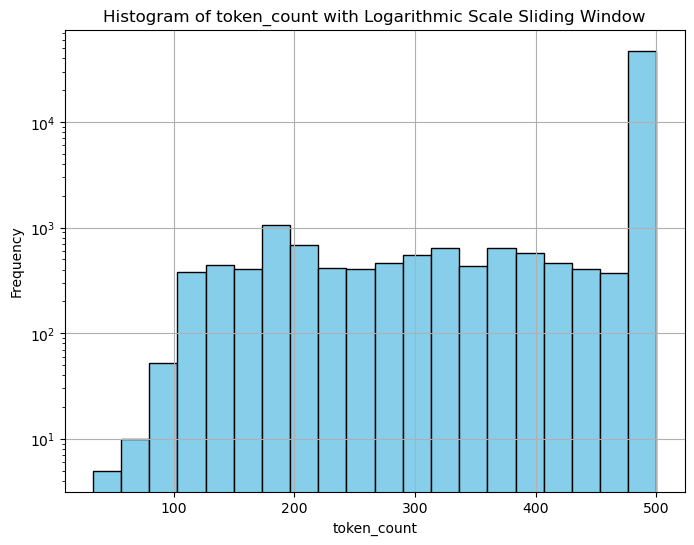

In [310]:
# Plot histogram with logarithmic scale on y-axis
plt.figure(figsize=(8, 6))
plt.hist(train_df_expanded['token_count'], bins=20, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.xlabel('token_count')
plt.ylabel('Frequency')
plt.title('Histogram of token_count with Logarithmic Scale Sliding Window')
plt.grid(True)
plt.show()

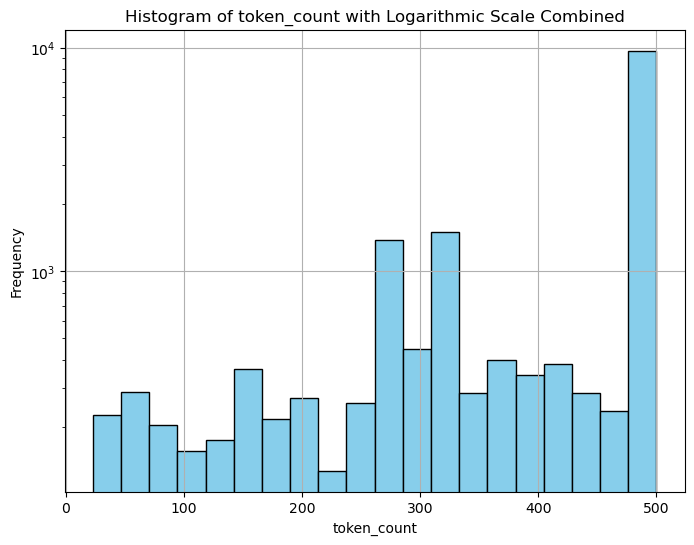

In [311]:
# Plot histogram with logarithmic scale on y-axis
plt.figure(figsize=(8, 6))
plt.hist(train_df_combined['token_count'], bins=20, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set logarithmic scale for y-axis
plt.xlabel('token_count')
plt.ylabel('Frequency')
plt.title('Histogram of token_count with Logarithmic Scale Combined')
plt.grid(True)
plt.show()

In [312]:
len(train_df[train_df['token_count'] <= 512])

6562

In [313]:
len(train_df[train_df['token_count'] > 512])

2340

In [314]:
len(train_df_expanded[train_df_expanded['token_count'] <= 512])

55937

In [315]:
len(train_df_expanded[train_df_expanded['token_count'] > 512])

0

In [316]:
len(train_df_combined[train_df_combined['token_count'] <= 512])

17256

In [317]:
len(train_df_combined[train_df_combined['token_count'] > 512])

0

In [231]:
train_df = train_df[train_df['token_count'] <= 512]
test_df = test_df[test_df['token_count'] <= 512]
val_df = val_df[val_df['token_count'] <= 512]
train_df_expanded = train_df_expanded[train_df_expanded['token_count'] <= 512]
test_df_expanded = test_df_expanded[test_df_expanded['token_count'] <= 512]
val_df_expanded = val_df_expanded[val_df_expanded['token_count'] <= 512]
train_df_combined = train_df_combined[train_df_combined['token_count'] <= 512]
test_df_combined = test_df_combined[test_df_combined['token_count'] <= 512]
val_df_combined = val_df_combined[val_df_combined['token_count'] <= 512]

In [318]:
def convert_dataframe_to_dataset(df):
    def transform_row(row):
        input_ids = row['tokenized']
        attention_mask = [1] * len(input_ids)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": row['slither']  # Assuming 'slither' is already in the correct format
        }
    
    df['slither'] = df['slither'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Explode the dataframe
    df_exploded = df.explode('slither')
    
    # Apply the transformation
    transformed_data = df_exploded.apply(transform_row, axis=1).tolist()
    
    # Convert to Dataset
    dataset = Dataset.from_pandas(pd.DataFrame(transformed_data))
    return dataset

In [319]:
train_dataset = convert_dataframe_to_dataset(train_df)
test_dataset = convert_dataframe_to_dataset(test_df)
val_dataset = convert_dataframe_to_dataset(val_df)

/tmp/ipykernel_268/2286320498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['slither'] = df['slither'].apply(lambda x: eval(x) if isinstance(x, str) else x)


In [320]:
train_dataset_expanded = convert_dataframe_to_dataset(train_df_expanded)
test_dataset_expanded = convert_dataframe_to_dataset(test_df_expanded)
val_dataset_expanded = convert_dataframe_to_dataset(val_df_expanded)

In [321]:
train_dataset_combined = convert_dataframe_to_dataset(train_df_combined)
test_dataset_combined = convert_dataframe_to_dataset(test_df_combined)
val_dataset_combined = convert_dataframe_to_dataset(val_df_combined)

In [322]:
datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
})

In [323]:
datasets_expanded = DatasetDict({
    "train": train_dataset_expanded,
    "test": test_dataset_expanded,
    "validation": val_dataset_expanded
})

In [324]:
datasets_combined = DatasetDict({
    "train": train_dataset_combined,
    "test": test_dataset_combined,
    "validation": val_dataset_combined
})

In [325]:
datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2178
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1451
    })
})

In [326]:
datasets_expanded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 67147
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14135
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9192
    })
})

In [327]:
datasets_combined

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21157
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4416
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2942
    })
})

In [328]:
# Save the dataset
save_path = "dataset/"
datasets.save_to_disk(save_path)
save_path = "dataset_expanded/"
datasets_expanded.save_to_disk(save_path)
save_path = "dataset_combined/"
datasets_combined.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/10426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1451 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/67147 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14135 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9192 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4416 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2942 [00:00<?, ? examples/s]

In [153]:
# Load Big dataset
# datasets = DatasetDict.load_from_disk(save_path)
# datasets

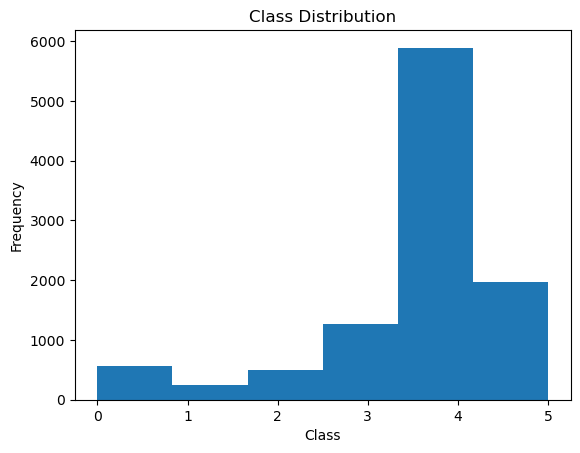

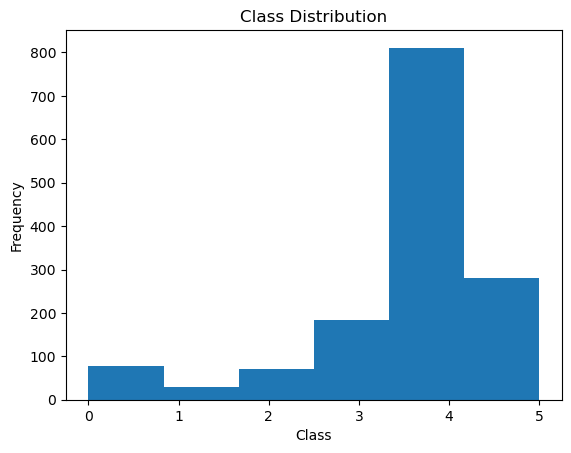

In [329]:
def plot_class_distribution(labels):
    plt.hist(labels, bins=len(set(labels)))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(datasets["train"]["labels"])
plot_class_distribution(datasets["validation"]["labels"])

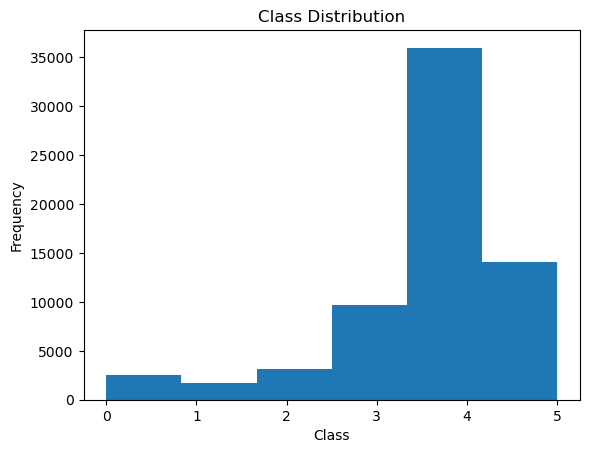

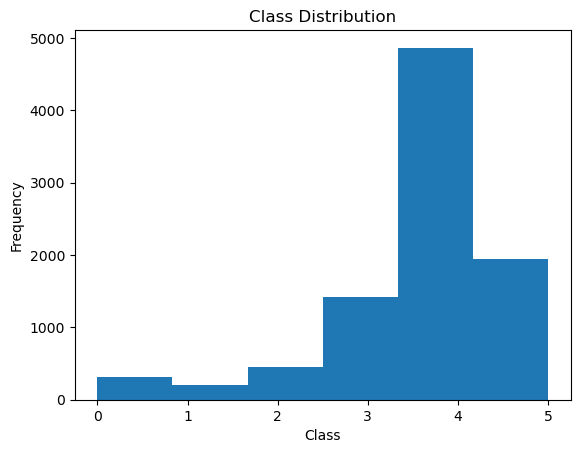

In [330]:
def plot_class_distribution(labels):
    plt.hist(labels, bins=len(set(labels)))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(datasets_expanded["train"]["labels"])
plot_class_distribution(datasets_expanded["validation"]["labels"])

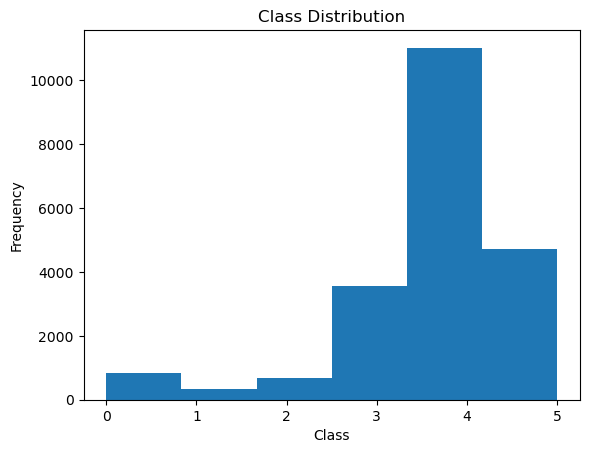

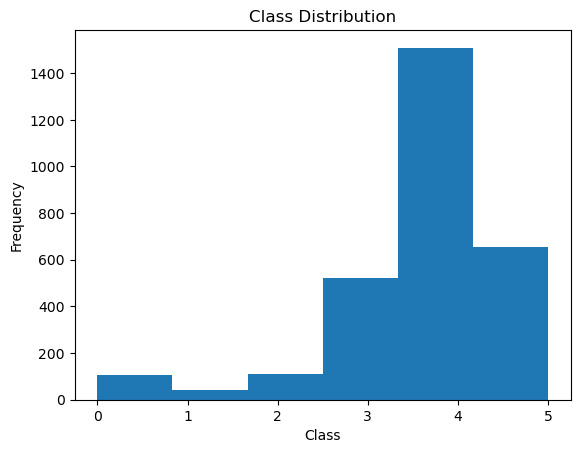

In [331]:
def plot_class_distribution(labels):
    plt.hist(labels, bins=len(set(labels)))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(datasets_combined["train"]["labels"])
plot_class_distribution(datasets_combined["validation"]["labels"])

## 3. Model Configuration

Model: https://huggingface.co/transformers/v2.9.1/model_doc/roberta.html#robertaforsequenceclassification

In [332]:
# Flatten the lists into a single list
flattened_list = [number for sublist in train_df['slither'] for number in sublist]

# Convert to a set to get unique numbers
unique_numbers = set(flattened_list)

# Get the count of unique numbers
unique_count = len(unique_numbers)

# Print the unique numbers and their count
print("Unique numbers:", unique_numbers)
print("Count of unique numbers:", unique_count)

Unique numbers: {0, 1, 2, 3, 4, 5}
Count of unique numbers: 6


In [334]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification

model_id = "microsoft/codebert-base"

print(f"Starting to load the model {model_id} into memory")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, 
        quantization_config=bnb_config, 
        device_map={"":0},
        num_labels=unique_count
    )
    print(f"Successfully loaded the model {model_id} into memory")
except Exception as e:
    print(f"Error loading model: {e}")

loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token

Starting to load the model microsoft/codebert-base into memory


loading weights file pytorch_model.bin from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/pytorch_model.bin
Instantiating RobertaForSequenceClassification model under default dtype torch.float16.
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassifica

Successfully loaded the model microsoft/codebert-base into memory


## 4. Model Training

#### Applying QLoRA

Method: https://github.com/artidoro/qlora

In [335]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [336]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=Tru

In [337]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [338]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    target_modules=["query", "key", "value", "dense"],  # Adjusted based on CodeBert Architecture
    lora_dropout=0.05, 
    bias="none", 
    task_type="SequenceClassification"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 1339392 || all params: 83227398 || trainable%: 1.6093162013787816


In [339]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = (preds == labels).mean()
    
    print("Labels: ", labels)
    print("Predictions: ", preds)
    print("Accuracy: ", accuracy)
    
    return {
        'accuracy': accuracy,
    }

#### On Reduced Tokens

In [344]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        warmup_steps=20,
        max_steps=200,
        #num_train_epochs=3
        learning_rate=1e-5,
        fp16=True,
        logging_steps=8,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        remove_unused_columns=False,  # To ensure all necessary columns are kept
    ),
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
***** Running training *****
  Num examples = 10,426
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 200
  Number of trainable parameters = 1,339,392
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

Step,Training Loss
8,1.559300
16,1.530000
24,1.521600
32,1.529700
40,1.462000
48,1.513200
56,1.371700
64,1.463800
72,1.347100
80,1.361900


Saving model checkpoint to outputs/checkpoint-200
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=200, training_loss=1.3752875518798828, metrics={'train_runtime': 454.9284, 'train_samples_per_second': 14.068, 'train_steps_per_second': 0.44, 'total_flos': 1710304749158400.0, 'train_loss': 1.3752875518798828, 'epoch': 0.6134969325153374})

In [346]:
trainer.save_model("models/")
tokenizer.save_pretrained("tokenizers/")

Saving model checkpoint to models/
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

tokenizer config file saved in tokenizers/tokenizer_config.json
Special tokens file saved in tokenizers/special_tokens

('tokenizers/tokenizer_config.json',
 'tokenizers/special_tokens_map.json',
 'tokenizers/vocab.json',
 'tokenizers/merges.txt',
 'tokenizers/added_tokens.json',
 'tokenizers/tokenizer.json')

In [347]:
prediction = trainer.predict(datasets["validation"])
predicted_labels = prediction.predictions[1]
y_hat = np.argmax(predicted_labels, axis=-1).flatten()
y = datasets["validation"]["labels"]

accuracy = accuracy_score(y, y_hat)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y, y_hat, average='weighted')

# auc = roc_auc_score(y, predicted_labels, multi_class='ovr', average='weighted')


with open('results/eval_results_' + datetime.now().strftime("%Y%m%d_%H%M%S"), 'w') as f:
    json.dump(f"Accuracy: {accuracy}" 
                + f", Precision: {precision}" 
                + f", Recall: {recall}" 
                + f", F1 Score: {f1}"
                # + f", RocAucScore: {auc}"
                , f, indent=4
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
#print(f"RocAucScore: {auc}")


***** Running Prediction *****
  Num examples = 1451
  Batch size = 8


Accuracy: 0.5589248793935218
Precision: 0.3123970208050628
Recall: 0.5589248793935218
F1 Score: 0.4007852141362918


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Sliding Window Approach instead of filtering

In [348]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification

model_id = "microsoft/codebert-base"

print(f"Starting to load the model {model_id} into memory")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, 
        quantization_config=bnb_config, 
        device_map={"":0},
        num_labels=unique_count
    )
    print(f"Successfully loaded the model {model_id} into memory")
except Exception as e:
    print(f"Error loading model: {e}")

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    target_modules=["query", "key", "value", "dense"],  # Adjusted based on CodeBert Architecture
    lora_dropout=0.05, 
    bias="none", 
    task_type="SequenceClassification"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token

Starting to load the model microsoft/codebert-base into memory


loading weights file pytorch_model.bin from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/pytorch_model.bin
Instantiating RobertaForSequenceClassification model under default dtype torch.float16.
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassifica

Successfully loaded the model microsoft/codebert-base into memory
trainable params: 1339392 || all params: 83227398 || trainable%: 1.6093162013787816


In [349]:
trainer_expanded = transformers.Trainer(
    model=model,
    train_dataset=datasets_expanded["train"],
    eval_dataset=datasets_expanded["validation"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        warmup_steps=20,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=8,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        remove_unused_columns=False,  # To ensure all necessary columns are kept
    ),
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer_expanded.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
***** Running training *****
  Num examples = 67,147
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 200
  Number of trainable parameters = 1,339,392
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

Step,Training Loss
8,1.846500
16,1.680000
24,1.437600
32,1.370000
40,1.323700
48,1.470000
56,1.257100
64,1.272700
72,1.344500
80,1.338000


Saving model checkpoint to outputs/checkpoint-200
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=200, training_loss=1.2992241477966309, metrics={'train_runtime': 455.1606, 'train_samples_per_second': 14.061, 'train_steps_per_second': 0.439, 'total_flos': 1710304749158400.0, 'train_loss': 1.2992241477966309, 'epoch': 0.09530617107457708})

In [350]:
trainer_expanded.save_model("models_expanded/")

Saving model checkpoint to models_expanded/
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [351]:
def sample_fraction(dataset, fraction):
    # Calculate the number of samples to take
    num_samples = int(len(dataset) * fraction)
    
    # Generate random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Select the samples
    sampled_dataset = dataset.select(indices)
    
    return sampled_dataset

data = sample_fraction(datasets_expanded["validation"], FRACTION)

prediction_expanded = trainer.predict(data)
predicted_labels_expanded = prediction_expanded.predictions[1]
y_hat_expanded = np.argmax(predicted_labels_expanded, axis=-1).flatten()
y_expanded = data["labels"]

accuracy = accuracy_score(y_expanded, y_hat_expanded)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_expanded, y_hat_expanded, average='weighted')

# auc = roc_auc_score(y, predicted_labels, multi_class='ovr', average='weighted')


with open('results/eval_results_expanded_' + datetime.now().strftime("%Y%m%d_%H%M%S"), 'w') as f:
    json.dump(f"Accuracy: {accuracy}" 
                + f", Precision: {precision}" 
                + f", Recall: {recall}" 
                + f", F1 Score: {f1}"
                # + f", RocAucScore: {auc}"
                , f, indent=4
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
#print(f"RocAucScore: {auc}")


***** Running Prediction *****
  Num examples = 9192
  Batch size = 8


Accuracy: 0.5290469973890339
Precision: 0.27989072544635246
Recall: 0.5290469973890339
F1 Score: 0.3660982637215044


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Combined Training

In [352]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification

model_id = "microsoft/codebert-base"

print(f"Starting to load the model {model_id} into memory")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, 
        quantization_config=bnb_config, 
        device_map={"":0},
        num_labels=unique_count
    )
    print(f"Successfully loaded the model {model_id} into memory")
except Exception as e:
    print(f"Error loading model: {e}")

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    target_modules=["query", "key", "value", "dense"],  # Adjusted based on CodeBert Architecture
    lora_dropout=0.05, 
    bias="none", 
    task_type="SequenceClassification"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token

Starting to load the model microsoft/codebert-base into memory


loading weights file pytorch_model.bin from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/pytorch_model.bin
Instantiating RobertaForSequenceClassification model under default dtype torch.float16.
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassifica

Successfully loaded the model microsoft/codebert-base into memory
trainable params: 1339392 || all params: 83227398 || trainable%: 1.6093162013787816


In [356]:
trainer_combined = transformers.Trainer(
    model=model,
    train_dataset=datasets_combined["train"],
    eval_dataset=datasets_combined["validation"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        warmup_steps=20,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=8,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        remove_unused_columns=False,  # To ensure all necessary columns are kept
    ),
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer_combined.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
***** Running training *****
  Num examples = 21,157
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 200
  Number of trainable parameters = 1,339,392
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

Step,Training Loss
8,0.892000
16,1.024100
24,0.957100
32,0.992600
40,0.916000
48,0.891700
56,0.858200
64,0.837500
72,0.850600
80,0.770500


Saving model checkpoint to outputs/checkpoint-200
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=200, training_loss=0.8342809724807739, metrics={'train_runtime': 452.4094, 'train_samples_per_second': 14.146, 'train_steps_per_second': 0.442, 'total_flos': 1710304749158400.0, 'train_loss': 0.8342809724807739, 'epoch': 0.30234315948601664})

In [357]:
trainer_combined.save_model("models_combined/")

Saving model checkpoint to models_combined/
loading configuration file config.json from cache at /home/e12329504/.cache/huggingface/hub/models--microsoft--codebert-base/snapshots/3b0952feddeffad0063f274080e3c23d75e7eb39/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [358]:
prediction_combined = trainer.predict(datasets_combined["validation"])
predicted_labels_combined = prediction_combined.predictions[1]
y_hat_combined = np.argmax(predicted_labels_combined, axis=-1).flatten()
y_combined = datasets_combined["validation"]["labels"]

accuracy = accuracy_score(y_combined, y_hat_combined)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_combined, y_hat_combined, average='weighted')

# auc = roc_auc_score(y, predicted_labels, multi_class='ovr', average='weighted')


with open('results/eval_results_combined_' + datetime.now().strftime("%Y%m%d_%H%M%S"), 'w') as f:
    json.dump(f"Accuracy: {accuracy}" 
                + f", Precision: {precision}" 
                + f", Recall: {recall}" 
                + f", F1 Score: {f1}"
                # + f", RocAucScore: {auc}"
                , f, indent=4
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
#print(f"RocAucScore: {auc}")


***** Running Prediction *****
  Num examples = 2942
  Batch size = 8


Accuracy: 0.5129163834126444
Precision: 0.2630832163731069
Recall: 0.5129163834126444
F1 Score: 0.3477828903930265


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /home/e12329504/shared/194.035-2024S/groups/Gruppe_16/Crypto/.git/


In [2]:
!git remote add origin https://github.com/DennisToma/CryptoAssetsAnalytics

In [4]:
!git add Crypto.ipynb results/eval_results_combined_20240626_124657 

In [7]:
!git config --global user.email "tomadennis1998@gmail.com"
!git config --global user.name "DennisToma"

In [8]:
!git commit -m "Initial commit"

[master (root-commit) 976bd8f] Initial commit
 2 files changed, 3893 insertions(+)
 create mode 100644 Crypto.ipynb
 create mode 100644 results/eval_results_combined_20240626_124657


In [ ]:
!git push -u origin master

Username for 'https://github.com': 